Starting IID MNIST random
Round: 0, Test Loss: 1.8314049987792969, Accuracy: 0.6465
Round: 10, Test Loss: 1.490041381072998, Accuracy: 0.9732
Round: 20, Test Loss: 1.4810823638916015, Accuracy: 0.9817
Round: 30, Test Loss: 1.477488274383545, Accuracy: 0.9846
Round: 40, Test Loss: 1.4762199096679687, Accuracy: 0.986
Round: 50, Test Loss: 1.4754623100280762, Accuracy: 0.9858
Round: 60, Test Loss: 1.4742023880004882, Accuracy: 0.9874
Round: 70, Test Loss: 1.4729228660583495, Accuracy: 0.9891
Round: 80, Test Loss: 1.472409253692627, Accuracy: 0.9892
Round: 90, Test Loss: 1.472092795562744, Accuracy: 0.9892
Round: 100, Test Loss: 1.4718221366882325, Accuracy: 0.9892
Round: 110, Test Loss: 1.470742517852783, Accuracy: 0.991
Round: 120, Test Loss: 1.470222861480713, Accuracy: 0.9918
Round: 130, Test Loss: 1.4709052276611327, Accuracy: 0.9907
Round: 140, Test Loss: 1.4702376808166504, Accuracy: 0.9913
Starting IID MNIST ABS
Round: 0, Test Loss: 1.7913474388122559, Accuracy: 0.6817
Round: 10, T

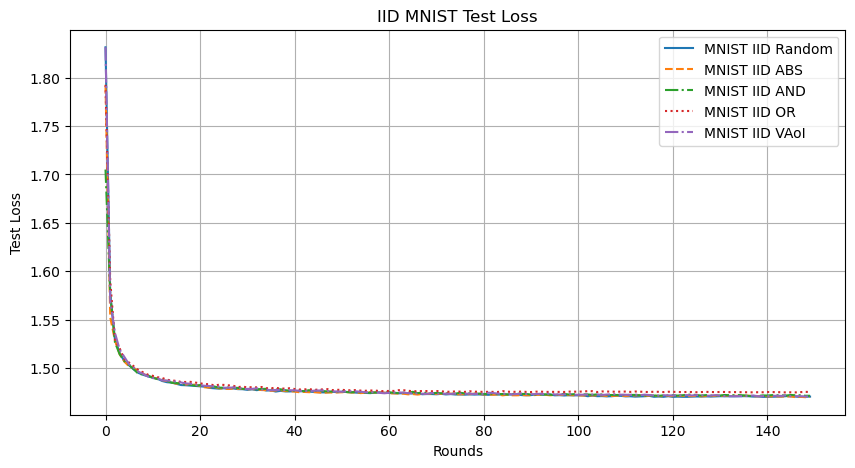

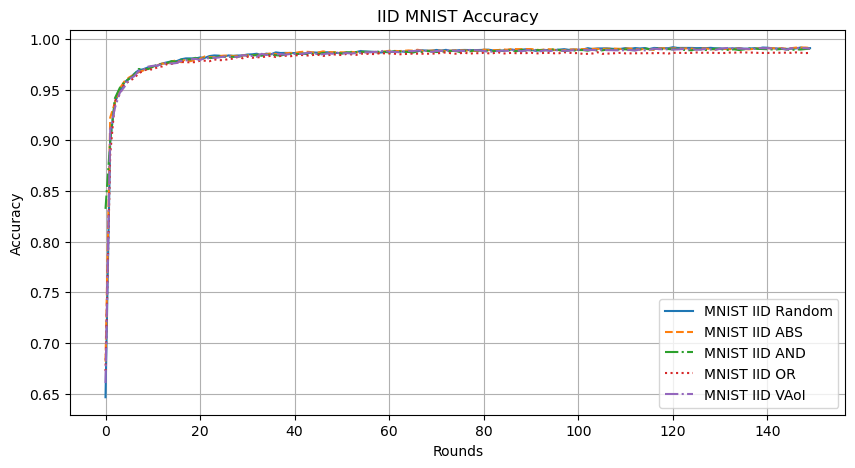

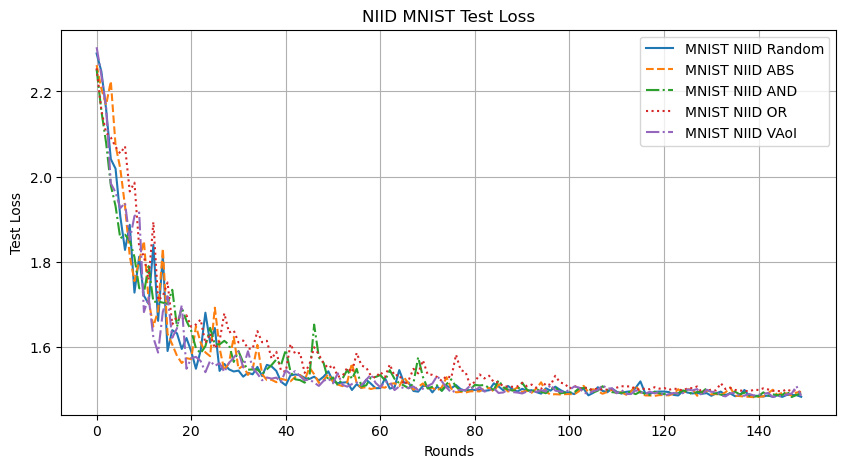

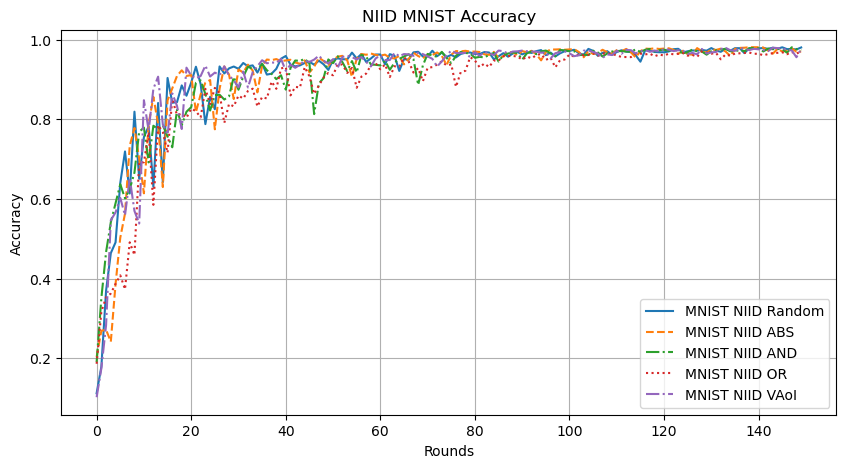

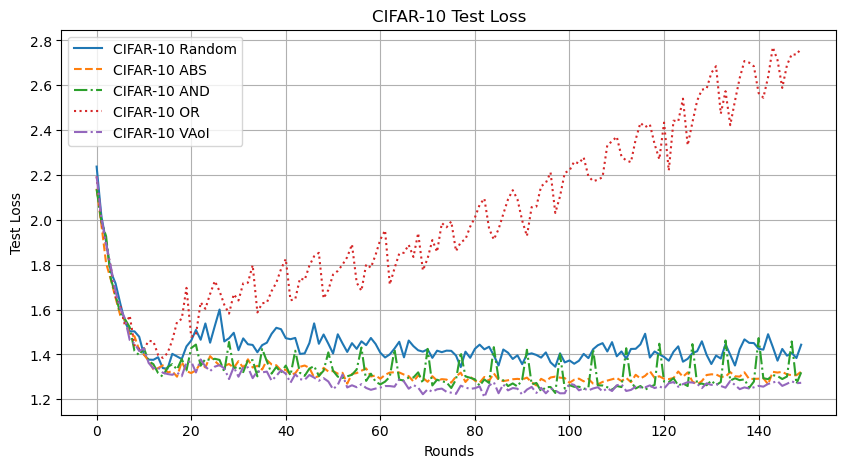

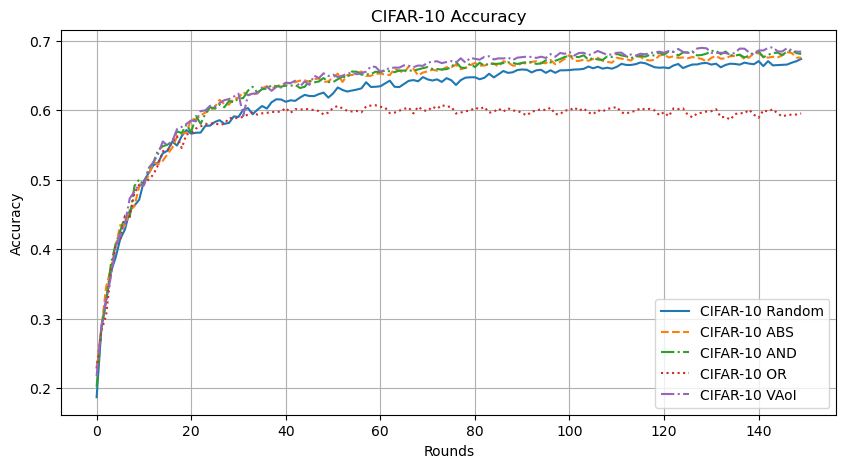

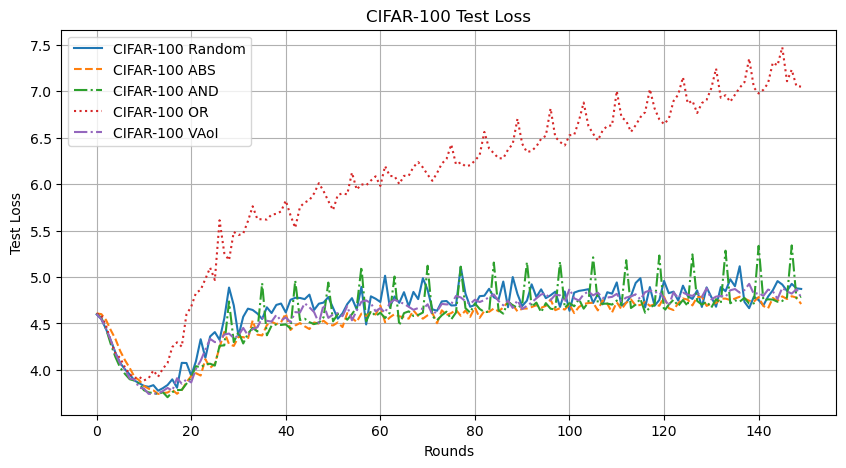

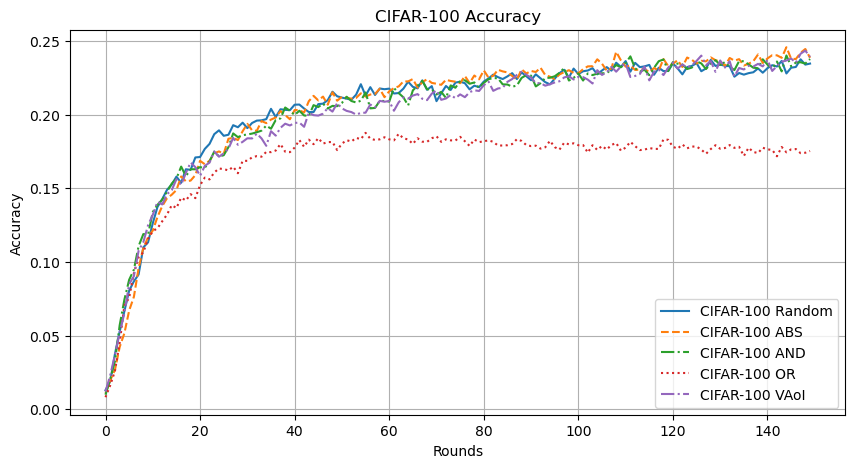

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimq
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_clients = 100
E = 5
mnist_B = 50
cifar_B = 50
mnist_iid_lr = 0.215
mnist_niid_lr = 0.1

cifar10_lr = 0.15
rounds = 150
clients_per_round = 5
num_shards = 200
shard_size = 300
shards_per_client = 2

"""
 __  __ _   _ ___ ____ _____    ____ _   _ _   _ 
|  \/  | \ | |_ _/ ___|_   _|  / ___| \ | | \ | |
| |\/| |  \| || |\___ \ | |   | |   |  \| |  \| |
| |  | | |\  || | ___) || |   | |___| |\  | |\  |
|_|  |_|_| \_|___|____/ |_|    \____|_| \_|_| \_|
"""

class mnistCNN(nn.Module):
    def __init__(self):
        super(mnistCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        # Output layer
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Convolutional layer 2 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 4 * 4)
        # Fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Output layer with softmax activation
        x = F.softmax(self.fc2(x), dim=1)
        return x

"""
  ____ ___ _____ _    ____     ____ _   _ _   _ 
 / ___|_ _|  ___/ \  |  _ \   / ___| \ | | \ | |
| |    | || |_ / _ \ | |_) | | |   |  \| |  \| |
| |___ | ||  _/ ___ \|  _ <  | |___| |\  | |\  |
 \____|___|_|/_/   \_\_| \_\  \____|_| \_|_| \_|
"""

class CIFARCNN(nn.Module):
    def __init__(self):
        super(CIFARCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.pool(x)  
        x = F.relu(self.conv2(x))  
        x = self.pool(x)  
        x = F.relu(self.conv3(x))  
        x = self.pool(x)
        x = self.flatten(x)  # Flatten the output
        x = F.relu(self.fc1(x))  # Apply dense layer with relu activation
        x = self.fc2(x)  # Apply final dense layer
        return x


class CIFAR100CNN(nn.Module):
    def __init__(self):
        super(CIFAR100CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 100)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.pool(x)  
        x = F.relu(self.conv2(x))  
        x = self.pool(x)  
        x = F.relu(self.conv3(x))  
        x = self.pool(x)
        x = self.flatten(x)  # Flatten the output
        x = F.relu(self.fc1(x))  # Apply dense layer with relu activation
        x = self.fc2(x)  # Apply final dense layer
        return x
"""
 ____        _          _                    _               
|  _ \  __ _| |_ __ _  | |    ___   __ _  __| | ___ _ __ ___ 
| | | |/ _` | __/ _` | | |   / _ \ / _` |/ _` |/ _ \ '__/ __|
| |_| | (_| | || (_| | | |__| (_) | (_| | (_| |  __/ |  \__ \
|____/ \__,_|\__\__,_| |_____\___/ \__,_|\__,_|\___|_|  |___/
"""
 
 # IID MNIST Loader
def iid_mnist_loader():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    traindata = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    traindata_split = torch.utils.data.random_split(traindata, [len(traindata) // num_clients for _ in range(num_clients)])
    train_loader = [DataLoader(x, batch_size=mnist_B, shuffle=True) for x in traindata_split]
    test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transform), batch_size=mnist_B, shuffle=False)
    return train_loader, test_loader

# Non-IID MNIST Loader

def mnist_noniid():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    num_shards, num_imgs = 200, 300
    idx_shard = [i for i in range(num_shards)]
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.targets.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()]
    idxs = idxs_labels[0,:]

    # divide and assign
    train_loader = []
    for i in range(num_clients):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        user_idxs = np.array([], dtype='int64')
        for rand in rand_set:
            user_idxs = np.concatenate((user_idxs, idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
        user_data = torch.utils.data.Subset(dataset, user_idxs)
        train_loader.append(torch.utils.data.DataLoader(user_data, batch_size=mnist_B, shuffle=True))
    
    test_loader = DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transform), batch_size=mnist_B, shuffle=True)

    return train_loader, test_loader

# CIFAR-10 Loader
def cifar_loader():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    traindata = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    traindata_split = torch.utils.data.random_split(traindata, [len(traindata) // num_clients for _ in range(num_clients)])
    train_loader = [DataLoader(x, batch_size=cifar_B, shuffle=True) for x in traindata_split]
    test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, download=True, transform=transform), batch_size=cifar_B, shuffle=False)
    return train_loader, test_loader

# CIFAR-100 Loader
def cifar100_loader():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    traindata = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    traindata_split = torch.utils.data.random_split(traindata, [len(traindata) // num_clients for _ in range(num_clients)])
    train_loader = [DataLoader(x, batch_size=cifar_B, shuffle=True) for x in traindata_split]
    test_loader = DataLoader(datasets.CIFAR100(root='./data', train=False, download=True, transform=transform), batch_size=cifar_B, shuffle=False)
    return train_loader, test_loader
"""
 ___       _ _   _       _ _          _   _             
|_ _|_ __ (_) |_(_) __ _| (_)______ _| |_(_) ___  _ __  
 | || '_ \| | __| |/ _` | | |_  / _` | __| |/ _ \| '_ \ 
 | || | | | | |_| | (_| | | |/ / (_| | |_| | (_) | | | |
|___|_| |_|_|\__|_|\__,_|_|_/___\__,_|\__|_|\___/|_| |_|
"""

def mnist_iid_initialization():

    global_model = mnistCNN().to(device)
    client_models = [mnistCNN().to(device) for _ in range(num_clients)]

    for model in client_models:
        model.load_state_dict(global_model.state_dict())
    client_optimizers = [optimq.SGD(model.parameters(), lr=mnist_iid_lr) for model in client_models]
    return global_model, client_optimizers, client_models

def mnist_non_iid_initialization():

    global_model = mnistCNN().to(device)
    client_models = [mnistCNN().to(device) for _ in range(num_clients)]

    for model in client_models:
        model.load_state_dict(global_model.state_dict())
    client_optimizers = [optimq.SGD(model.parameters(), lr=mnist_niid_lr) for model in client_models]
    return global_model, client_optimizers, client_models

def cifar_initialization():

    global_model = CIFARCNN().to(device)
    client_models = [CIFARCNN().to(device) for _ in range(num_clients)]

    for model in client_models:
        model.load_state_dict(global_model.state_dict())
    client_optimizers = [optimq.SGD(model.parameters(), lr=cifar10_lr) for model in client_models]
    return global_model, client_optimizers, client_models

def cifar100_initialization():
    
        global_model = CIFAR100CNN().to(device)
        client_models = [CIFAR100CNN().to(device) for _ in range(num_clients)]
    
        for model in client_models:
            model.load_state_dict(global_model.state_dict())
        client_optimizers = [optimq.SGD(model.parameters(), lr=cifar10_lr) for model in client_models]
        return global_model, client_optimizers, client_models
"""
 _____ _       _____                 _   _                 
|  ___| |     |  ___|   _ _ __   ___| |_(_) ___  _ __  ___ 
| |_  | |     | |_ | | | | '_ \ / __| __| |/ _ \| '_ \/ __|
|  _| | |___  |  _|| |_| | | | | (__| |_| | (_) | | | \__ \
|_|   |_____| |_|   \__,_|_| |_|\___|\__|_|\___/|_| |_|___/
"""

def server_average(client_models, global_model):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
            
    global_model.load_state_dict(global_dict)
    
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

def train_client(model, epochs, train_loader_client, optimizer):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader_client):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

def test_client(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    return accuracy

def test_global(global_model, test_loader):
    global_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    return test_loss, accuracy

def run_fl():
    global_losses = []
    global_accuracies = []
    for r in range(rounds):
        selected_models_list = []
        selected_clients = np.random.permutation(num_clients)[:clients_per_round]
        for client_id in selected_clients:
            client_models[client_id].load_state_dict(global_model.state_dict()) # Reset client model to global model
            train_client(client_models[client_id], E, train_loader[client_id], client_optimizers[client_id])
            selected_models_list.append(client_models[client_id]) # Save the model after training
        server_average(selected_models_list, global_model)
        test_loss, accuracy = test_global(global_model, test_loader)
        global_losses.append(test_loss)
        global_accuracies.append(accuracy)
        if r % 10 == 0:
            print(f'Round: {r}, Test Loss: {test_loss}, Accuracy: {accuracy}')

    return global_losses, global_accuracies


def run_fl_ABS():
    global_losses = []
    global_accuracies = []
    client_ages = np.zeros(num_clients)

    for r in range(rounds):
        oldest_client_idx = np.argsort(client_ages)[-clients_per_round:]
        client_ages += 1
        client_ages[oldest_client_idx] = 0
        selected_clients = oldest_client_idx
        selected_models_list = []
        for client_id in selected_clients:
            client_models[client_id].load_state_dict(global_model.state_dict()) # Reset client model to global model
            train_client(client_models[client_id], E, train_loader[client_id], client_optimizers[client_id])
            selected_models_list.append(client_models[client_id]) # Save the model after training
        server_average(selected_models_list, global_model)
        test_loss, accuracy = test_global(global_model, test_loader)
        global_losses.append(test_loss)
        global_accuracies.append(accuracy)
        if r % 10 == 0:
            print(f'Round: {r}, Test Loss: {test_loss}, Accuracy: {accuracy}')

    return global_losses, global_accuracies

def run_fl_data_shapley_AND():
    global_losses = []
    global_accuracies = []
    client_ages = np.zeros(num_clients)
    client_accuracies = np.zeros((num_clients,2))
    client_performance_scores = np.random.rand(num_clients)
    age_threshold = 5
    performance_threshold = 0.8
    # average_ages = []
    # average_scores = []
    for r in range(rounds):
        selected_clients, client_ages = select_clients_performance_AND(client_ages, client_performance_scores, clients_per_round, age_threshold) # select client based on age and performance
        selected_models_list = []
        # Train selected clients
        for client_id in selected_clients:
            client_accuracies[client_id][0] = client_accuracies[client_id][1]
            # Load global model to client model
            client_models[client_id].load_state_dict(global_model.state_dict())
            train_client(client_models[client_id], E, train_loader[client_id], client_optimizers[client_id])
            selected_models_list.append(client_models[client_id])
            client_accuracies[client_id][1] = test_client(client_models[client_id], test_loader)
            
        client_performance_scores = calculate_performance_score(client_accuracies, client_performance_scores, selected_clients, performance_threshold)
        # average_ages.append(np.mean(client_ages))
        # average_scores.append(np.mean(client_performance_scores))
        server_average(selected_models_list, global_model) # Update global model
        test_loss, accuracy = test_global(global_model, test_loader)
        global_losses.append(test_loss)
        global_accuracies.append(accuracy)
        if r % 10 == 0:
            print(f'Round: {r}, Test Loss: {test_loss}, Accuracy: {accuracy}')
    return global_losses, global_accuracies

def run_fl_data_shapley_OR():
    global_losses = []
    global_accuracies = []
    client_ages = np.zeros(num_clients)
    client_accuracies = np.zeros((num_clients,2))
    client_performance_scores = np.random.rand(num_clients)
    age_threshold = 5
    performance_threshold = 0.8
    # average_ages = []
    # average_scores = []
    for r in range(rounds):
        selected_clients, client_ages = select_clients_performance_OR(client_ages, client_performance_scores, clients_per_round, age_threshold) # select client based on age and performance
        selected_models_list = []
        # Train selected clients
        for client_id in selected_clients:
            client_accuracies[client_id][0] = client_accuracies[client_id][1]
            # Load global model to client model
            client_models[client_id].load_state_dict(global_model.state_dict())
            train_client(client_models[client_id], E, train_loader[client_id], client_optimizers[client_id])
            selected_models_list.append(client_models[client_id])
            client_accuracies[client_id][1] = test_client(client_models[client_id], test_loader)
            
        client_performance_scores = calculate_performance_score(client_accuracies, client_performance_scores, selected_clients, performance_threshold)
        # average_ages.append(np.mean(client_ages))
        # average_scores.append(np.mean(client_performance_scores))
        server_average(selected_models_list, global_model) # Update global model
        test_loss, accuracy = test_global(global_model, test_loader)
        global_losses.append(test_loss)
        global_accuracies.append(accuracy)
        if r % 10 == 0:
            print(f'Round: {r}, Test Loss: {test_loss}, Accuracy: {accuracy}')
    return global_losses, global_accuracies

def calculate_performance_score(client_accuracies, client_performance_scores, selected_clients, performance_threshold):
    for client_id in selected_clients:
        varience = np.var(client_accuracies[client_id])
        original_performance = client_performance_scores[client_id]
        if varience > performance_threshold:
            client_performance_scores[client_id] += 1
        
        client_performance_scores[client_id] = (original_performance + client_performance_scores[client_id]) / 2

    return client_performance_scores
    
def select_clients_performance_AND(client_ages, client_performance_scores, clients_per_round, age_threshold):
    # Select clients whose age exceeds the threshold
    oldest_client_idx = np.where(client_ages > age_threshold)[0]

    # Select clients with the highest performance scores
    highest_performance_idx = np.argsort(client_performance_scores)[-clients_per_round:]

    # Select clients who are both old and have high performance scores
    selected_clients = np.intersect1d(oldest_client_idx, highest_performance_idx)

    if len(selected_clients) < clients_per_round:
        # If not enough clients are selected, fill in the rest by selecting the clients with the highest ages and performance scores
        remaining_clients = np.setdiff1d(np.arange(len(client_ages)), selected_clients)
        top_remaining_clients = np.argsort(client_ages[remaining_clients] + client_performance_scores[remaining_clients])[-(clients_per_round - len(selected_clients)):]
        selected_clients = np.concatenate([selected_clients, remaining_clients[top_remaining_clients]])

    if len(selected_clients) > clients_per_round:
        selected_clients = selected_clients[:clients_per_round]

    # Update client ages 
    # np.square(client_ages, out=client_ages)
    client_ages += 1
    client_ages[selected_clients] = 0
    return selected_clients, client_ages

def select_clients_performance_OR(client_ages, client_performance_scores, clients_per_round, age_threshold):
    # Select clients whose age exceeds the threshold
    oldest_client_idx = np.where(client_ages > age_threshold)[0]

    # Select clients with the highest performance scores
    highest_performance_idx = np.argsort(client_performance_scores)[-clients_per_round:]

    # Select clients who are either old or have high performance scores
    selected_clients = np.union1d(oldest_client_idx, highest_performance_idx)
    if len(selected_clients) < clients_per_round:
        # If not enough clients are selected, fill in the rest by selecting the clients with the highest ages and performance scores
        remaining_clients = np.setdiff1d(np.arange(len(client_ages)), selected_clients)
        top_remaining_clients = np.argsort(client_ages[remaining_clients] + client_performance_scores[remaining_clients])[-(clients_per_round - len(selected_clients)):]
        selected_clients = np.concatenate([selected_clients, remaining_clients[top_remaining_clients]])
    
    if len(selected_clients) > clients_per_round:
        selected_clients = selected_clients[:clients_per_round]
    
    # np.square(client_ages, out=client_ages)
    client_ages += 1
    client_ages[selected_clients] = 0
    return selected_clients, client_ages

def manhattan_norm(client_model, global_model):
    client_weights = client_model.state_dict()
    global_weights = global_model.state_dict()
    for key in client_weights.keys():
        norm = torch.norm(client_weights[key] - global_weights[key], p=1)
        norm = norm.item()
    return norm

def run_fl_VAoI():
    version_threshold = 0.19
    global_losses = []
    global_accuracies = []
    client_versions = np.zeros(num_clients)
    client_indices = np.arange(num_clients)

    for r in range(rounds):
        selected_models_list = []
        h = np.exp(client_versions)
        probabilities = h / np.sum(h)
        selected_clients = np.random.choice(client_indices, clients_per_round, replace=False, p=probabilities)
        unselected_clients = np.setdiff1d(client_indices, selected_clients)
        for client_id in unselected_clients:
            client_norm = manhattan_norm(client_models[client_id], global_model)
            if client_norm > version_threshold:
                client_versions[client_id] += 1        

        for client_id in selected_clients:
            client_models[client_id].load_state_dict(global_model.state_dict())
            client_versions[client_id] = 0
            train_client(client_models[client_id], E, train_loader[client_id], client_optimizers[client_id])
            selected_models_list.append(client_models[client_id])
        server_average(selected_models_list, global_model)
        test_loss, accuracy = test_global(global_model, test_loader)
        global_losses.append(test_loss)
        global_accuracies.append(accuracy)
        if r % 10 == 0:
            print(f'Round: {r}, Test Loss: {test_loss}, Accuracy: {accuracy}')
    return global_losses, global_accuracies

print("Starting IID MNIST random")
train_loader, test_loader = iid_mnist_loader()
global_model, client_optimizers, client_models = mnist_iid_initialization()
mnist_global_losses_iid_rand, mnist_global_accuracies_iid_rand = run_fl()

print("Starting IID MNIST ABS")
train_loader, test_loader = iid_mnist_loader()
global_model, client_optimizers, client_models = mnist_iid_initialization()
mnist_global_losses_iid_abs, mnist_global_accuracies_iid_abs = run_fl_ABS()

print("Starting IID MNIST AND")
train_loader, test_loader = iid_mnist_loader()
global_model, client_optimizers, client_models = mnist_iid_initialization()
mnist_global_losses_iid_AND, mnist_global_accuracies_iid_AND = run_fl_data_shapley_AND()

print("Starting IID MNIST OR")
train_loader, test_loader = iid_mnist_loader()
global_model, client_optimizers, client_models = mnist_iid_initialization()
mnist_global_losses_iid_OR, mnist_global_accuracies_iid_OR = run_fl_data_shapley_OR()

print("Starting IID MNIST VAoI")
train_loader, test_loader = iid_mnist_loader()
global_model, client_optimizers, client_models = mnist_iid_initialization()
mnist_global_losses_iid_VAoI, mnist_global_accuracies_iid_VAoI = run_fl_VAoI()

print("Starting NIID MNIST random")
train_loader, test_loader = mnist_noniid()
global_model, client_optimizers, client_models = mnist_non_iid_initialization()
mnist_global_losses_niid_rand, mnist_global_accuracies_niid_rand = run_fl()

print("Starting NIID MNIST ABS")
train_loader, test_loader = mnist_noniid()
global_model, client_optimizers, client_models = mnist_non_iid_initialization()
mnist_global_losses_niid_abs, mnist_global_accuracies_niid_abs = run_fl_ABS()

print("Starting NIID MNIST AND")
train_loader, test_loader = mnist_noniid()
global_model, client_optimizers, client_models = mnist_non_iid_initialization()
mnist_global_losses_niid_AND, mnist_global_accuracies_niid_AND = run_fl_data_shapley_AND()

print("Starting NIID MNIST OR")
train_loader, test_loader = mnist_noniid()
global_model, client_optimizers, client_models = mnist_non_iid_initialization()
mnist_global_losses_niid_OR, mnist_global_accuracies_niid_OR = run_fl_data_shapley_OR()

print("Starting NIID MNIST VAoI")
train_loader, test_loader = mnist_noniid()
global_model, client_optimizers, client_models = mnist_non_iid_initialization()
mnist_global_losses_niid_VAoI, mnist_global_accuracies_niid_VAoI = run_fl_VAoI()

print("Starting CIFAR-10 random")
train_loader, test_loader = cifar_loader()
global_model, client_optimizers, client_models = cifar_initialization()
cifar_global_losses_rand, cifar_global_accuracies_rand = run_fl()

print("Starting CIFAR-10 ABS")
train_loader, test_loader = cifar_loader()
global_model, client_optimizers, client_models = cifar_initialization()
cifar_global_losses_abs, cifar_global_accuracies_abs = run_fl_ABS()

print("Starting CIFAR-10 AND")
train_loader, test_loader = cifar_loader()
global_model, client_optimizers, client_models = cifar_initialization()
cifar_global_losses_AND, cifar_global_accuracies_AND = run_fl_data_shapley_AND()

print("Starting CIFAR-10 OR")
train_loader, test_loader = cifar_loader()
global_model, client_optimizers, client_models = cifar_initialization()
cifar_global_losses_OR, cifar_global_accuracies_OR = run_fl_data_shapley_OR()

print("Starting CIFAR-10 VAoI")
train_loader, test_loader = cifar_loader()
global_model, client_optimizers, client_models = cifar_initialization()
cifar_global_losses_VAoI, cifar_global_accuracies_VAoI = run_fl_VAoI()

print("Starting CIFAR-100 random")
train_loader, test_loader = cifar100_loader()
global_model, client_optimizers, client_models = cifar100_initialization()
cifar100_global_losses_rand, cifar100_global_accuracies_rand = run_fl()

print("Starting CIFAR-100 ABS")
train_loader, test_loader = cifar100_loader()
global_model, client_optimizers, client_models = cifar100_initialization()
cifar100_global_losses_abs, cifar100_global_accuracies_abs = run_fl_ABS()

print("Starting CIFAR-100 AND")
train_loader, test_loader = cifar100_loader()
global_model, client_optimizers, client_models = cifar100_initialization()
cifar100_global_losses_AND, cifar100_global_accuracies_AND = run_fl_data_shapley_AND()

print("Starting CIFAR-100 OR")
train_loader, test_loader = cifar100_loader()
global_model, client_optimizers, client_models = cifar100_initialization()
cifar100_global_losses_OR, cifar100_global_accuracies_OR = run_fl_data_shapley_OR()

print("Starting CIFAR-100 VAoI")
train_loader, test_loader = cifar100_loader()
global_model, client_optimizers, client_models = cifar100_initialization()
cifar100_global_losses_VAoI, cifar100_global_accuracies_VAoI = run_fl_VAoI()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_losses_iid_rand, label='MNIST IID Random')
plt.plot(mnist_global_losses_iid_abs, label='MNIST IID ABS', linestyle='dashed')
plt.plot(mnist_global_losses_iid_AND, label='MNIST IID AND', linestyle='dashdot')
plt.plot(mnist_global_losses_iid_OR, label='MNIST IID OR', linestyle='dotted')
plt.plot(mnist_global_losses_iid_VAoI, label='MNIST IID VAoI', linestyle='dashdot')
plt.title('IID MNIST Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_accuracies_iid_rand, label='MNIST IID Random')
plt.plot(mnist_global_accuracies_iid_abs, label='MNIST IID ABS', linestyle='dashed')
plt.plot(mnist_global_accuracies_iid_AND, label='MNIST IID AND', linestyle='dashdot')
plt.plot(mnist_global_accuracies_iid_OR, label='MNIST IID OR', linestyle='dotted')
plt.plot(mnist_global_accuracies_iid_VAoI, label='MNIST IID VAoI', linestyle='dashdot')
plt.title('IID MNIST Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_accuracies_iid_rand, label='MNIST IID Random')
plt.plot(mnist_global_accuracies_iid_abs, label='MNIST IID ABS', linestyle='dashed')
plt.plot(mnist_global_accuracies_iid_AND, label='MNIST IID AND', linestyle='dashdot')
plt.plot(mnist_global_accuracies_iid_OR, label='MNIST IID OR', linestyle='dotted')
plt.plot(mnist_global_accuracies_iid_VAoI, label='MNIST IID VAoI', linestyle='dashdot')
plt.title('IID MNIST Accuracy (Zoomed In)')
plt.ylim(0.95, 1)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_losses_niid_rand, label='MNIST NIID Random')
plt.plot(mnist_global_losses_niid_abs, label='MNIST NIID ABS', linestyle='dashed')
plt.plot(mnist_global_losses_niid_AND, label='MNIST NIID AND', linestyle='dashdot')
plt.plot(mnist_global_losses_niid_OR, label='MNIST NIID OR', linestyle='dotted')
plt.plot(mnist_global_losses_niid_VAoI, label='MNIST NIID VAoI', linestyle='dashdot')
plt.title('NIID MNIST Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_accuracies_niid_rand, label='MNIST NIID Random')
plt.plot(mnist_global_accuracies_niid_abs, label='MNIST NIID ABS', linestyle='dashed')
plt.plot(mnist_global_accuracies_niid_AND, label='MNIST NIID AND', linestyle='dashdot')
plt.plot(mnist_global_accuracies_niid_OR, label='MNIST NIID OR', linestyle='dotted')
plt.plot(mnist_global_accuracies_niid_VAoI, label='MNIST NIID VAoI', linestyle='dashdot')
plt.title('NIID MNIST Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_accuracies_niid_rand, label='MNIST NIID Random')
plt.plot(mnist_global_accuracies_niid_abs, label='MNIST NIID ABS', linestyle='dashed')
plt.plot(mnist_global_accuracies_niid_AND, label='MNIST NIID AND', linestyle='dashdot')
plt.plot(mnist_global_accuracies_niid_OR, label='MNIST NIID OR', linestyle='dotted')
plt.plot(mnist_global_accuracies_niid_VAoI, label='MNIST NIID VAoI', linestyle='dashdot')
plt.title('NIID MNIST Accuracy (Zoomed In)')
plt.ylim(0.95, 1)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar_global_losses_rand, label='CIFAR-10 Random')
plt.plot(cifar_global_losses_abs, label='CIFAR-10 ABS', linestyle='dashed')
plt.plot(cifar_global_losses_AND, label='CIFAR-10 AND', linestyle='dashdot')
plt.plot(cifar_global_losses_OR, label='CIFAR-10 OR', linestyle='dotted')
plt.plot(cifar_global_losses_VAoI, label='CIFAR-10 VAoI', linestyle='dashdot')
plt.title('CIFAR-10 Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar_global_accuracies_rand, label='CIFAR-10 Random')
plt.plot(cifar_global_accuracies_abs, label='CIFAR-10 ABS', linestyle='dashed')
plt.plot(cifar_global_accuracies_AND, label='CIFAR-10 AND', linestyle='dashdot')
plt.plot(cifar_global_accuracies_OR, label='CIFAR-10 OR', linestyle='dotted')
plt.plot(cifar_global_accuracies_VAoI, label='CIFAR-10 VAoI', linestyle='dashdot')
plt.title('CIFAR-10 Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar_global_accuracies_rand, label='CIFAR-10 Random')
plt.plot(cifar_global_accuracies_abs, label='CIFAR-10 ABS', linestyle='dashed')
plt.plot(cifar_global_accuracies_AND, label='CIFAR-10 AND', linestyle='dashdot')
plt.plot(cifar_global_accuracies_OR, label='CIFAR-10 OR', linestyle='dotted')
plt.plot(cifar_global_accuracies_VAoI, label='CIFAR-10 VAoI', linestyle='dashdot')
plt.title('CIFAR-10 Accuracy (Zoomed In)')
plt.ylim(0.59, 0.7)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar100_global_losses_rand, label='CIFAR-100 Random')
plt.plot(cifar100_global_losses_abs, label='CIFAR-100 ABS', linestyle='dashed')
plt.plot(cifar100_global_losses_AND, label='CIFAR-100 AND', linestyle='dashdot')
plt.plot(cifar100_global_losses_OR, label='CIFAR-100 OR', linestyle='dotted')
plt.plot(cifar100_global_losses_VAoI, label='CIFAR-100 VAoI', linestyle='dashdot')
plt.title('CIFAR-100 Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar100_global_accuracies_rand, label='CIFAR-100 Random')
plt.plot(cifar100_global_accuracies_abs, label='CIFAR-100 ABS', linestyle='dashed')
plt.plot(cifar100_global_accuracies_AND, label='CIFAR-100 AND', linestyle='dashdot')
plt.plot(cifar100_global_accuracies_OR, label='CIFAR-100 OR', linestyle='dotted')
plt.plot(cifar100_global_accuracies_VAoI, label='CIFAR-100 VAoI', linestyle='dashdot')
plt.title('CIFAR-100 Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar100_global_accuracies_rand, label='CIFAR-100 Random')
plt.plot(cifar100_global_accuracies_abs, label='CIFAR-100 ABS', linestyle='dashed')
plt.plot(cifar100_global_accuracies_AND, label='CIFAR-100 AND', linestyle='dashdot')
plt.plot(cifar100_global_accuracies_OR, label='CIFAR-100 OR', linestyle='dotted')
plt.plot(cifar100_global_accuracies_VAoI, label='CIFAR-100 VAoI', linestyle='dashdot')
plt.title('CIFAR-100 Accuracy (Zoomed In)')
plt.ylim(0.2, 0.3)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


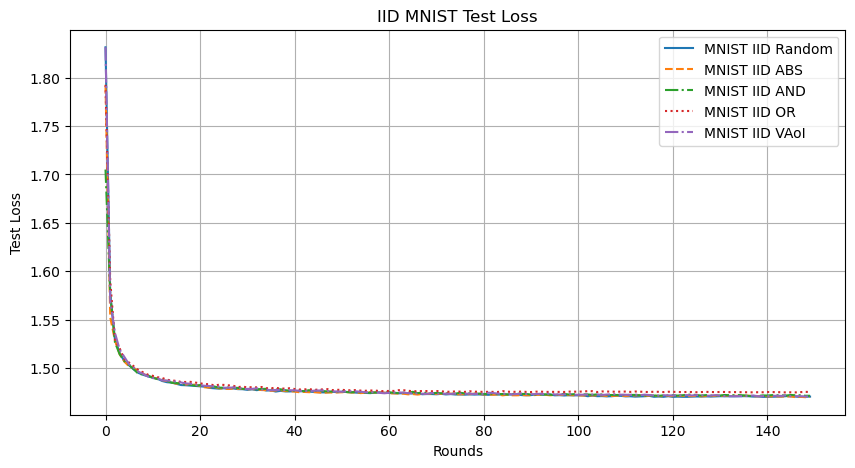

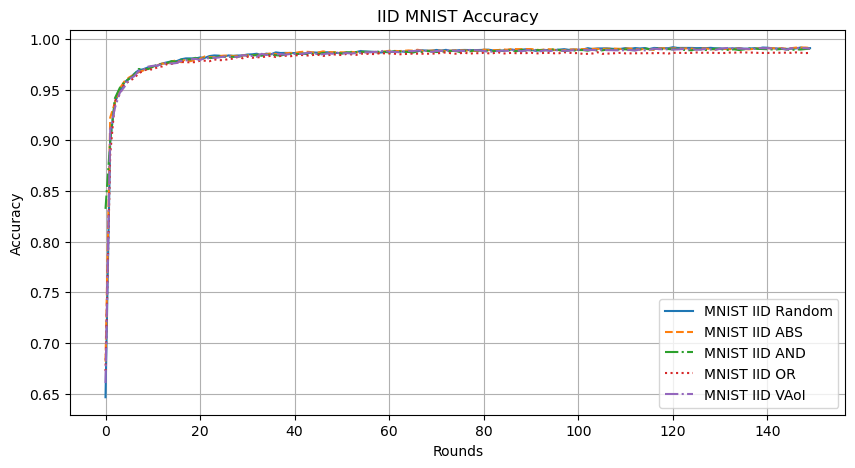

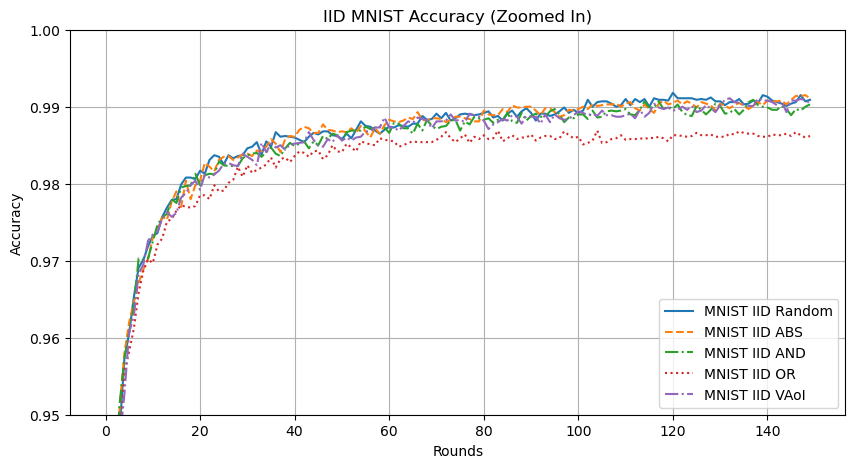

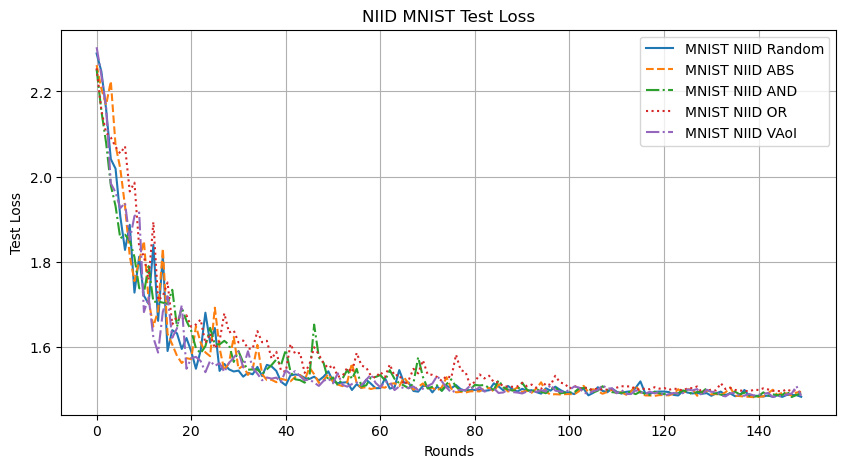

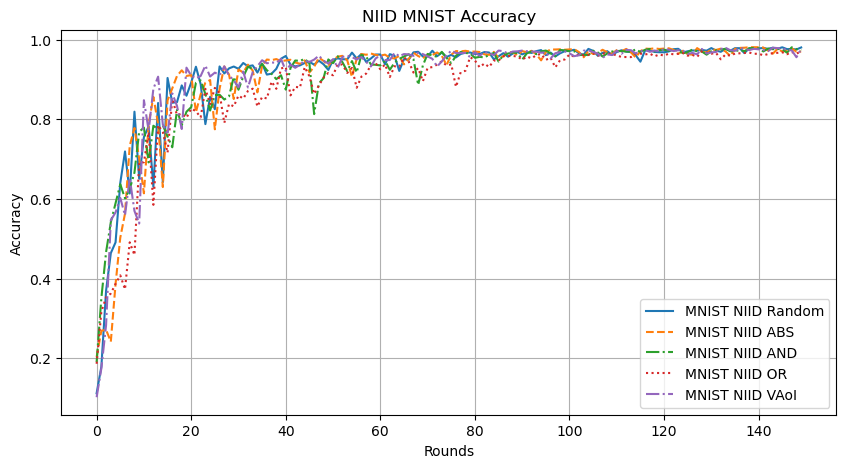

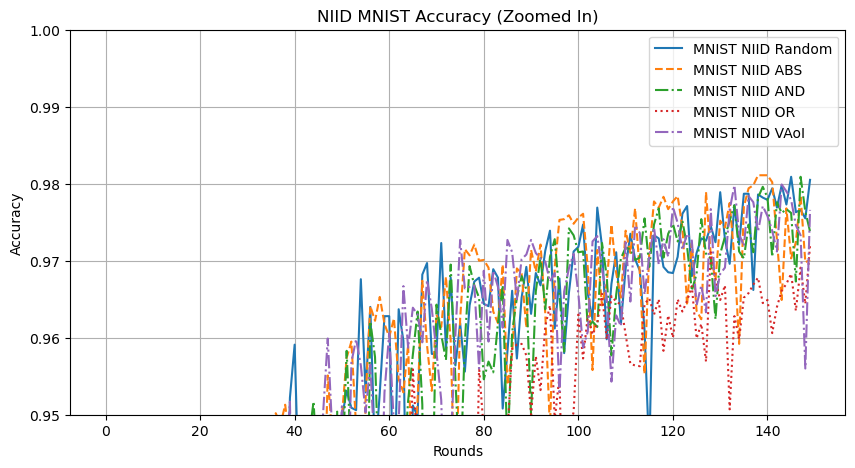

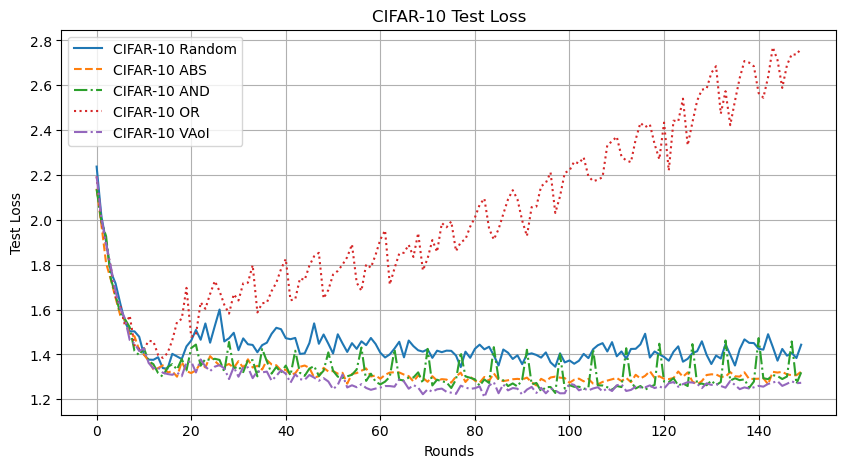

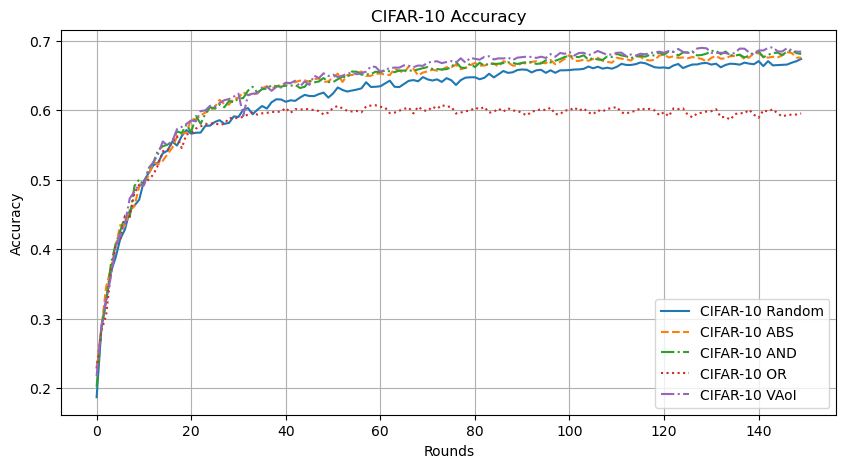

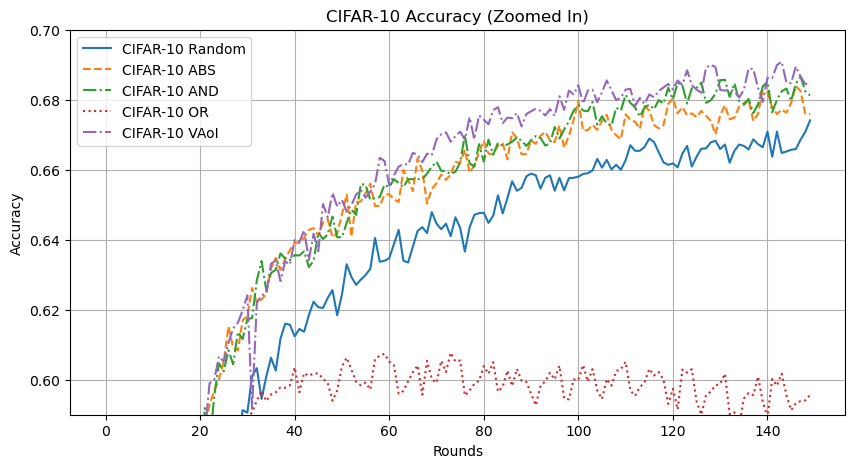

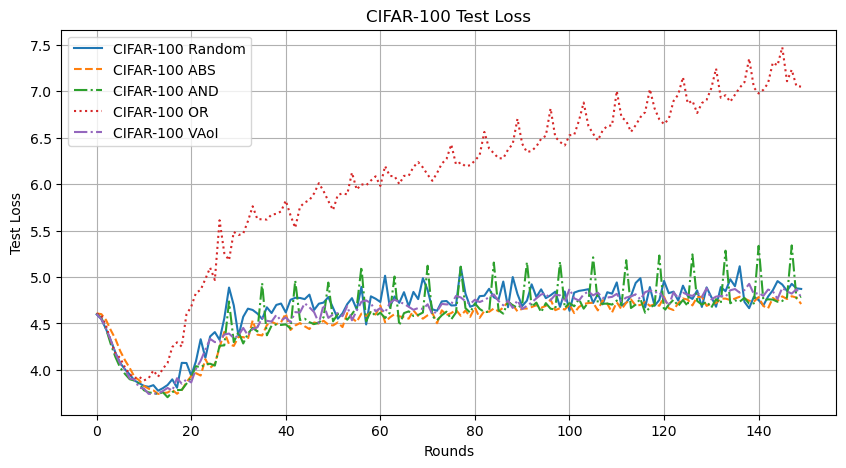

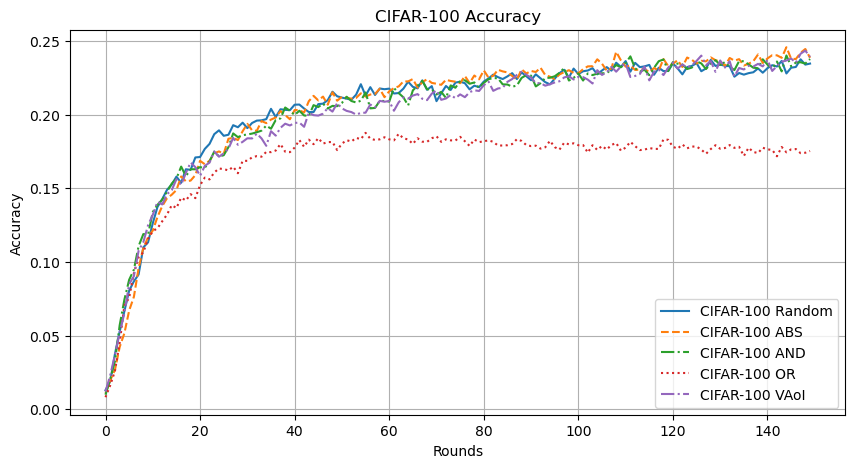

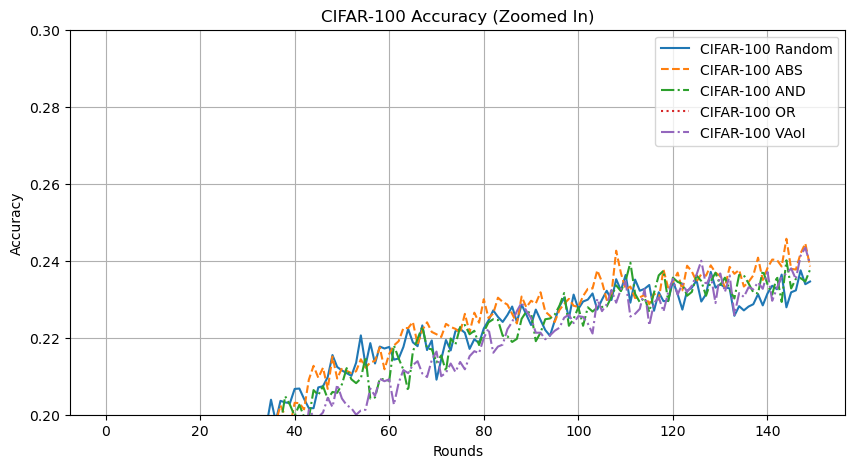

In [2]:
plt.figure(figsize=(10, 5))
plt.plot(mnist_global_losses_iid_rand, label='MNIST IID Random')
plt.plot(mnist_global_losses_iid_abs, label='MNIST IID ABS', linestyle='dashed')
plt.plot(mnist_global_losses_iid_AND, label='MNIST IID AND', linestyle='dashdot')
plt.plot(mnist_global_losses_iid_OR, label='MNIST IID OR', linestyle='dotted')
plt.plot(mnist_global_losses_iid_VAoI, label='MNIST IID VAoI', linestyle='dashdot')
plt.title('IID MNIST Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_accuracies_iid_rand, label='MNIST IID Random')
plt.plot(mnist_global_accuracies_iid_abs, label='MNIST IID ABS', linestyle='dashed')
plt.plot(mnist_global_accuracies_iid_AND, label='MNIST IID AND', linestyle='dashdot')
plt.plot(mnist_global_accuracies_iid_OR, label='MNIST IID OR', linestyle='dotted')
plt.plot(mnist_global_accuracies_iid_VAoI, label='MNIST IID VAoI', linestyle='dashdot')
plt.title('IID MNIST Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_accuracies_iid_rand, label='MNIST IID Random')
plt.plot(mnist_global_accuracies_iid_abs, label='MNIST IID ABS', linestyle='dashed')
plt.plot(mnist_global_accuracies_iid_AND, label='MNIST IID AND', linestyle='dashdot')
plt.plot(mnist_global_accuracies_iid_OR, label='MNIST IID OR', linestyle='dotted')
plt.plot(mnist_global_accuracies_iid_VAoI, label='MNIST IID VAoI', linestyle='dashdot')
plt.title('IID MNIST Accuracy (Zoomed In)')
plt.ylim(0.95, 1)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_losses_niid_rand, label='MNIST NIID Random')
plt.plot(mnist_global_losses_niid_abs, label='MNIST NIID ABS', linestyle='dashed')
plt.plot(mnist_global_losses_niid_AND, label='MNIST NIID AND', linestyle='dashdot')
plt.plot(mnist_global_losses_niid_OR, label='MNIST NIID OR', linestyle='dotted')
plt.plot(mnist_global_losses_niid_VAoI, label='MNIST NIID VAoI', linestyle='dashdot')
plt.title('NIID MNIST Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_accuracies_niid_rand, label='MNIST NIID Random')
plt.plot(mnist_global_accuracies_niid_abs, label='MNIST NIID ABS', linestyle='dashed')
plt.plot(mnist_global_accuracies_niid_AND, label='MNIST NIID AND', linestyle='dashdot')
plt.plot(mnist_global_accuracies_niid_OR, label='MNIST NIID OR', linestyle='dotted')
plt.plot(mnist_global_accuracies_niid_VAoI, label='MNIST NIID VAoI', linestyle='dashdot')
plt.title('NIID MNIST Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_accuracies_niid_rand, label='MNIST NIID Random')
plt.plot(mnist_global_accuracies_niid_abs, label='MNIST NIID ABS', linestyle='dashed')
plt.plot(mnist_global_accuracies_niid_AND, label='MNIST NIID AND', linestyle='dashdot')
plt.plot(mnist_global_accuracies_niid_OR, label='MNIST NIID OR', linestyle='dotted')
plt.plot(mnist_global_accuracies_niid_VAoI, label='MNIST NIID VAoI', linestyle='dashdot')
plt.title('NIID MNIST Accuracy (Zoomed In)')
plt.ylim(0.95, 1)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar_global_losses_rand, label='CIFAR-10 Random')
plt.plot(cifar_global_losses_abs, label='CIFAR-10 ABS', linestyle='dashed')
plt.plot(cifar_global_losses_AND, label='CIFAR-10 AND', linestyle='dashdot')
plt.plot(cifar_global_losses_OR, label='CIFAR-10 OR', linestyle='dotted')
plt.plot(cifar_global_losses_VAoI, label='CIFAR-10 VAoI', linestyle='dashdot')
plt.title('CIFAR-10 Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar_global_accuracies_rand, label='CIFAR-10 Random')
plt.plot(cifar_global_accuracies_abs, label='CIFAR-10 ABS', linestyle='dashed')
plt.plot(cifar_global_accuracies_AND, label='CIFAR-10 AND', linestyle='dashdot')
plt.plot(cifar_global_accuracies_OR, label='CIFAR-10 OR', linestyle='dotted')
plt.plot(cifar_global_accuracies_VAoI, label='CIFAR-10 VAoI', linestyle='dashdot')
plt.title('CIFAR-10 Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar_global_accuracies_rand, label='CIFAR-10 Random')
plt.plot(cifar_global_accuracies_abs, label='CIFAR-10 ABS', linestyle='dashed')
plt.plot(cifar_global_accuracies_AND, label='CIFAR-10 AND', linestyle='dashdot')
plt.plot(cifar_global_accuracies_OR, label='CIFAR-10 OR', linestyle='dotted')
plt.plot(cifar_global_accuracies_VAoI, label='CIFAR-10 VAoI', linestyle='dashdot')
plt.title('CIFAR-10 Accuracy (Zoomed In)')
plt.ylim(0.59, 0.7)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar100_global_losses_rand, label='CIFAR-100 Random')
plt.plot(cifar100_global_losses_abs, label='CIFAR-100 ABS', linestyle='dashed')
plt.plot(cifar100_global_losses_AND, label='CIFAR-100 AND', linestyle='dashdot')
plt.plot(cifar100_global_losses_OR, label='CIFAR-100 OR', linestyle='dotted')
plt.plot(cifar100_global_losses_VAoI, label='CIFAR-100 VAoI', linestyle='dashdot')
plt.title('CIFAR-100 Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar100_global_accuracies_rand, label='CIFAR-100 Random')
plt.plot(cifar100_global_accuracies_abs, label='CIFAR-100 ABS', linestyle='dashed')
plt.plot(cifar100_global_accuracies_AND, label='CIFAR-100 AND', linestyle='dashdot')
plt.plot(cifar100_global_accuracies_OR, label='CIFAR-100 OR', linestyle='dotted')
plt.plot(cifar100_global_accuracies_VAoI, label='CIFAR-100 VAoI', linestyle='dashdot')
plt.title('CIFAR-100 Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar100_global_accuracies_rand, label='CIFAR-100 Random')
plt.plot(cifar100_global_accuracies_abs, label='CIFAR-100 ABS', linestyle='dashed')
plt.plot(cifar100_global_accuracies_AND, label='CIFAR-100 AND', linestyle='dashdot')
plt.plot(cifar100_global_accuracies_OR, label='CIFAR-100 OR', linestyle='dotted')
plt.plot(cifar100_global_accuracies_VAoI, label='CIFAR-100 VAoI', linestyle='dashdot')
plt.title('CIFAR-100 Accuracy (Zoomed In)')
plt.ylim(0.2, 0.3)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [3]:

print("MNIST IID")
print("Final Accuracy for MNIST IID Random:", mnist_global_accuracies_iid_rand[-1])
print("Final Accuracy for MNIST IID ABS:", mnist_global_accuracies_iid_abs[-1])
print("Final Accuracy for MNIST IID AND:", mnist_global_accuracies_iid_AND[-1])
print("Final Accuracy for MNIST IID OR:", mnist_global_accuracies_iid_OR[-1])
print("Final Accuracy for MNIST IID VAoI:", mnist_global_accuracies_iid_VAoI[-1])
print(" ")
print("MNIST NIID")
print("Final Accuracy for MNIST NIID Random:", mnist_global_accuracies_niid_rand[-1])
print("Final Accuracy for MNIST NIID ABS:", mnist_global_accuracies_niid_abs[-1])
print("Final Accuracy for MNIST NIID AND:", mnist_global_accuracies_niid_AND[-1])
print("Final Accuracy for MNIST NIID OR:", mnist_global_accuracies_niid_OR[-1])
print("Final Accuracy for MNIST NIID VAoI:", mnist_global_accuracies_niid_VAoI[-1])
print(" ")
print("CIFAR-10")
print("Final Accuracy for CIFAR-10 Random:", cifar_global_accuracies_rand[-1])
print("Final Accuracy for CIFAR-10 ABS:", cifar_global_accuracies_abs[-1])
print("Final Accuracy for CIFAR-10 AND:", cifar_global_accuracies_AND[-1])
print("Final Accuracy for CIFAR-10 OR:", cifar_global_accuracies_OR[-1])
print("Final Accuracy for CIFAR-10 VAoI:", cifar_global_accuracies_VAoI[-1])
print(" ")
print("CIFAR-100")
print("Final Accuracy for CIFAR-100 Random:", cifar100_global_accuracies_rand[-1])
print("Final Accuracy for CIFAR-100 ABS:", cifar100_global_accuracies_abs[-1])
print("Final Accuracy for CIFAR-100 AND:", cifar100_global_accuracies_AND[-1])
print("Final Accuracy for CIFAR-100 OR:", cifar100_global_accuracies_OR[-1])
print("Final Accuracy for CIFAR-100 VAoI:", cifar100_global_accuracies_VAoI[-1])
print(" ")
print("MNIST IID")
print("Final Loss for MNIST IID Random:", mnist_global_losses_iid_rand[-1])
print("Final Loss for MNIST IID ABS:", mnist_global_losses_iid_abs[-1])
print("Final Loss for MNIST IID AND:", mnist_global_losses_iid_AND[-1])
print("Final Loss for MNIST IID OR:", mnist_global_losses_iid_OR[-1])
print("Final Loss for MNIST IID VAoI:", mnist_global_losses_iid_VAoI[-1])
print(" ")
print("MNIST NIID")
print("Final Loss for MNIST NIID Random:", mnist_global_losses_niid_rand[-1])
print("Final Loss for MNIST NIID ABS:", mnist_global_losses_niid_abs[-1])
print("Final Loss for MNIST NIID AND:", mnist_global_losses_niid_AND[-1])
print("Final Loss for MNIST NIID OR:", mnist_global_losses_niid_OR[-1])
print("Final Loss for MNIST NIID VAoI:", mnist_global_losses_niid_VAoI[-1])
print(" ")
print("CIFAR-10")
print("Final Loss for CIFAR-10 Random:", cifar_global_losses_rand[-1])
print("Final Loss for CIFAR-10 ABS:", cifar_global_losses_abs[-1])
print("Final Loss for CIFAR-10 AND:", cifar_global_losses_AND[-1])
print("Final Loss for CIFAR-10 OR:", cifar_global_losses_OR[-1])
print("Final Loss for CIFAR-10 VAoI:", cifar_global_losses_VAoI[-1])
print(" ")
print("CIFAR-100")
print("Final Loss for CIFAR-100 Random:", cifar100_global_losses_rand[-1])
print("Final Loss for CIFAR-100 ABS:", cifar100_global_losses_abs[-1])
print("Final Loss for CIFAR-100 AND:", cifar100_global_losses_AND[-1])
print("Final Loss for CIFAR-100 OR:", cifar100_global_losses_OR[-1])
print("Final Loss for CIFAR-100 VAoI:", cifar100_global_losses_VAoI[-1])


MNIST IID
Final Accuracy for MNIST IID Random: 0.9909
Final Accuracy for MNIST IID ABS: 0.9911
Final Accuracy for MNIST IID AND: 0.9903
Final Accuracy for MNIST IID OR: 0.9862
Final Accuracy for MNIST IID VAoI: 0.9904
 
MNIST NIID
Final Accuracy for MNIST NIID Random: 0.9805
Final Accuracy for MNIST NIID ABS: 0.9701
Final Accuracy for MNIST NIID AND: 0.9738
Final Accuracy for MNIST NIID OR: 0.972
Final Accuracy for MNIST NIID VAoI: 0.9766
 
CIFAR-10
Final Accuracy for CIFAR-10 Random: 0.6741
Final Accuracy for CIFAR-10 ABS: 0.6759
Final Accuracy for CIFAR-10 AND: 0.6812
Final Accuracy for CIFAR-10 OR: 0.5956
Final Accuracy for CIFAR-10 VAoI: 0.6845
 
CIFAR-100
Final Accuracy for CIFAR-100 Random: 0.2346
Final Accuracy for CIFAR-100 ABS: 0.2385
Final Accuracy for CIFAR-100 AND: 0.2377
Final Accuracy for CIFAR-100 OR: 0.1753
Final Accuracy for CIFAR-100 VAoI: 0.2391
 
MNIST IID
Final Loss for MNIST IID Random: 1.4704882881164552
Final Loss for MNIST IID ABS: 1.4704173614501954
Final Loss

In [7]:
from prettytable import PrettyTable

# Create the table
table = PrettyTable()
table.field_names = ["Dataset", "Accuracy", "Loss"]

# Add the data to the table
table.add_row(["MNIST IID Random", mnist_global_accuracies_iid_rand[-1], mnist_global_losses_iid_rand[-1]])
table.add_row(["MNIST IID ABS", mnist_global_accuracies_iid_abs[-1], mnist_global_losses_iid_abs[-1]])
table.add_row(["MNIST IID AND", mnist_global_accuracies_iid_AND[-1], mnist_global_losses_iid_AND[-1]])
table.add_row(["MNIST IID OR", mnist_global_accuracies_iid_OR[-1], mnist_global_losses_iid_OR[-1]])
table.add_row(["MNIST IID VAoI", mnist_global_accuracies_iid_VAoI[-1], mnist_global_losses_iid_VAoI[-1]])

table.add_row(["MNIST NIID Random", mnist_global_accuracies_niid_rand[-1], mnist_global_losses_niid_rand[-1]])
table.add_row(["MNIST NIID ABS", mnist_global_accuracies_niid_abs[-1], mnist_global_losses_niid_abs[-1]])
table.add_row(["MNIST NIID AND", mnist_global_accuracies_niid_AND[-1], mnist_global_losses_niid_AND[-1]])
table.add_row(["MNIST NIID OR", mnist_global_accuracies_niid_OR[-1], mnist_global_losses_niid_OR[-1]])
table.add_row(["MNIST NIID VAoI", mnist_global_accuracies_niid_VAoI[-1], mnist_global_losses_niid_VAoI[-1]])

table.add_row(["CIFAR-10 Random", cifar_global_accuracies_rand[-1], cifar_global_losses_rand[-1]])
table.add_row(["CIFAR-10 ABS", cifar_global_accuracies_abs[-1], cifar_global_losses_abs[-1]])
table.add_row(["CIFAR-10 AND", cifar_global_accuracies_AND[-1], cifar_global_losses_AND[-1]])
table.add_row(["CIFAR-10 OR", cifar_global_accuracies_OR[-1], cifar_global_losses_OR[-1]])
table.add_row(["CIFAR-10 VAoI", cifar_global_accuracies_VAoI[-1], cifar_global_losses_VAoI[-1]])

table.add_row(["CIFAR-100 Random", cifar100_global_accuracies_rand[-1], cifar100_global_losses_rand[-1]])
table.add_row(["CIFAR-100 ABS", cifar100_global_accuracies_abs[-1], cifar100_global_losses_abs[-1]])
table.add_row(["CIFAR-100 AND", cifar100_global_accuracies_AND[-1], cifar100_global_losses_AND[-1]])
table.add_row(["CIFAR-100 OR", cifar100_global_accuracies_OR[-1], cifar100_global_losses_OR[-1]])
table.add_row(["CIFAR-100 VAoI", cifar100_global_accuracies_VAoI[-1], cifar100_global_losses_VAoI[-1]])

# Print the table
print(table)


+-------------------+----------+--------------------+
|      Dataset      | Accuracy |        Loss        |
+-------------------+----------+--------------------+
|  MNIST IID Random |  0.9909  | 1.4704882881164552 |
|   MNIST IID ABS   |  0.9911  | 1.4704173614501954 |
|   MNIST IID AND   |  0.9903  | 1.4713577934265136 |
|    MNIST IID OR   |  0.9862  | 1.4752463645935059 |
|   MNIST IID VAoI  |  0.9904  | 1.471023365020752  |
| MNIST NIID Random |  0.9805  | 1.4835163551330566 |
|   MNIST NIID ABS  |  0.9701  | 1.4953362106323242 |
|   MNIST NIID AND  |  0.9738  | 1.4917166542053222 |
|   MNIST NIID OR   |  0.972   | 1.4923665710449219 |
|  MNIST NIID VAoI  |  0.9766  | 1.4858879440307617 |
|  CIFAR-10 Random  |  0.6741  | 1.4436954818725587 |
|    CIFAR-10 ABS   |  0.6759  | 1.3235013870239258 |
|    CIFAR-10 AND   |  0.6812  | 1.3204061876296997 |
|    CIFAR-10 OR    |  0.5956  | 2.765282841491699  |
|   CIFAR-10 VAoI   |  0.6845  | 1.2738140720367432 |
|  CIFAR-100 Random |  0.234